# Sentiment Classification


### Generate Word Embeddings and retrieve outputs of each layer with Keras based on Classification task

Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation.

It is a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.

We willl use the imdb dataset to learn word embeddings as we train our dataset. This dataset contains 25,000 movie reviews from IMDB, labeled with sentiment (positive or negative). 



### Dataset

`from keras.datasets import imdb`

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, the words are indexed by their frequency in the dataset, meaning the for that has index 1 is the most frequent word. Use the first 20 words from each review to speed up training, using a max vocab size of 10,000.

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.


### Aim

1. Import test and train data  
2. Import the labels ( train and test) 
3. Get the word index and then Create key value pair for word and word_id. (12.5 points)
4. Build a Sequential Model using Keras for Sentiment Classification task. (10 points)
5. Report the Accuracy of the model. (5 points)  
6. Retrive the output of each layer in keras for a given single test sample from the trained model you built. (2.5 points)


#### Usage:

In [145]:
import numpy as np
import seaborn as sns
from sklearn import metrics

from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

import matplotlib.pyplot as plt
%matplotlib inline

from keras.callbacks import ModelCheckpoint, EarlyStopping

In [118]:
from keras.datasets import imdb

vocab_size = 10000 #vocab size

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size) # vocab_size is no.of words to consider from the dataset, ordering based on frequency.

In [119]:
from keras.preprocessing.sequence import pad_sequences
# vocab_size = 10000 #vocab size
maxlen = 300  #number of word used from each review

In [120]:
#load dataset as a list of ints
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
#make all sequences of the same length
x_train_pad = pad_sequences(x_train, maxlen=maxlen)
x_test_pad =  pad_sequences(x_test, maxlen=maxlen)

In [121]:
x_train_pad.shape

(25000, 300)

In [122]:
#total # of unique words
print(len(np.unique(np.hstack(x_train_pad))))

9999


In [123]:
print(np.unique(y_test))

[0 1]


In [124]:
x_train_pad.shape

(25000, 300)

In [125]:
!mkdir model_checkpoints # folder for saving checkpoints
!mkdir models # folder for saving models for future use
!mkdir cnf # folder for saving models for future use

mkdir: model_checkpoints: File exists
mkdir: models: File exists
mkdir: cnf: File exists


In [133]:
# utility fxn to plot model history and accuracy for each epoch
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# callback utility fxn for tensorboard, Initializing Early stopping and Model chekpoint callbacks**
# these fxn will be passed in model.fit 
def EarlyStoppingModelCheckPoint():
    #tensorboard = TensorBoard(log_dir=".logs/{}".format(time.time()))

    #Adding Early stopping callback to the fit function is going to stop the training,
    #if the val_loss is not going to change even '0.001' for more than 5 continous epochs

    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

    #Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves 
    # a new low value. Hence saving the best weights occurred during training

    model_checkpoint =  ModelCheckpoint('model_checkpoints/checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                               monitor='val_loss',
                                                               verbose=1,
                                                               save_best_only=True,
                                                               save_weights_only=True,
                                                               mode='auto',
                                                               period=1)
    return early_stopping, model_checkpoint

review = ['Positive', 'Negative']

def plot_cnf_matrix(cnf_matrix, name):
    fig, ax = plt.subplots(1, figsize=(12,5))
    ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
    ax.set_xticklabels(review)
    ax.set_yticklabels(review)
    plt.title('Confusion Matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    fig.savefig('cnf/{}.png'.format(name), dpi=300)
    plt.show();
    
def get1D_y_predict(y_pred):
    result = []
    for i in range(len(y_pred)):
        if(y_pred[i][0] > 0.50):
            result.append(1)
        else:
            result.append(0)
    return result

## Build Keras Embedding Layer Model
We can think of the Embedding layer as a dicionary that maps a index assigned to a word to a word vector. This layer is very flexible and can be used in a few ways:

* The embedding layer can be used at the start of a larger deep learning model. 
* Also we could load pre-train word embeddings into the embedding layer when we create our model.
* Use the embedding layer to train our own word2vec models.

The keras embedding layer doesn't require us to onehot encode our words, instead we have to give each word a unqiue intger number as an id. For the imdb dataset we've loaded this has already been done, but if this wasn't the case we could use sklearn [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [134]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=maxlen))
model.add(
    SimpleRNN(
        1, return_sequences=False, dropout=0.1, batch_input_shape=(vocab_size, maxlen,1)))
model.add(Dense(1, activation='sigmoid'))

In [135]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [136]:
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 8)            80000     
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 1)                 10        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 2         
Total params: 80,012
Trainable params: 80,012
Non-trainable params: 0
_________________________________________________________________
None


In [137]:
early_stopping, model_checkpoint = EarlyStoppingModelCheckPoint()

In [138]:
# fit the model
history1 = model.fit(x_train_pad, y_train, 
                     epochs=50, 
                     verbose=1, 
                     batch_size=vocab_size, 
                     validation_data=(x_test_pad, y_test), 
                     callbacks=[early_stopping, model_checkpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 3s 127us/step - loss: 0.6956 - acc: 0.4979 - val_loss: 0.6949 - val_acc: 0.5025

Epoch 00001: val_loss improved from inf to 0.69493, saving model to model_checkpoints/checkpoint_01_loss0.6949.h5
Epoch 2/50
25000/25000 [==============================] - 2s 70us/step - loss: 0.6914 - acc: 0.5268 - val_loss: 0.6941 - val_acc: 0.5082

Epoch 00002: val_loss improved from 0.69493 to 0.69412, saving model to model_checkpoints/checkpoint_02_loss0.6941.h5
Epoch 3/50
25000/25000 [==============================] - 2s 66us/step - loss: 0.6884 - acc: 0.5447 - val_loss: 0.6934 - val_acc: 0.5126

Epoch 00003: val_loss improved from 0.69412 to 0.69342, saving model to model_checkpoints/checkpoint_03_loss0.6934.h5
Epoch 4/50
25000/25000 [==============================] - 2s 65us/step - loss: 0.6858 - acc: 0.5616 - val_loss: 0.6928 - val_acc: 0.5127

Epoch 00004: val_loss improved from 0.69342 to 

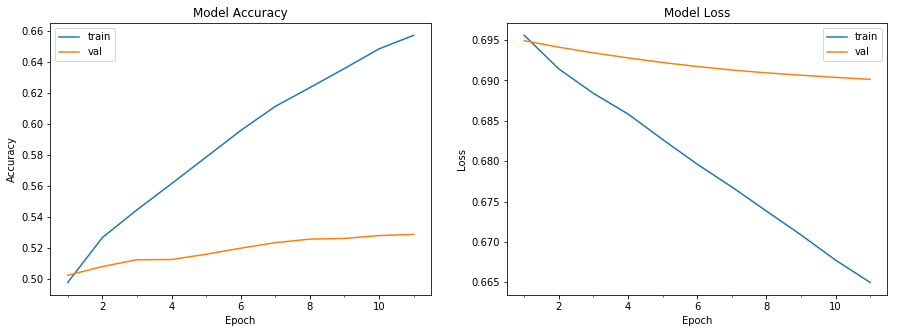

In [142]:
# plot model history
plot_model_history(history1)

In [143]:
# evaluate the model
loss, accuracy = model.evaluate(x_test_pad, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))



25000/25000 [==============================] - 12s 462us/step
Accuracy: 52.892000


In [146]:
# predict test data and get classification report
y_pred = model.predict(x_test_pad)
ypred = get1D_y_predict(y_pred)

# classification report with model accuracy and F1 score
cr = metrics.classification_report(y_test,ypred)
print("Classification Report: \n\n", cr)

Classification Report: 

               precision    recall  f1-score   support

           0       0.53      0.51      0.52     12500
           1       0.53      0.55      0.54     12500

   micro avg       0.53      0.53      0.53     25000
   macro avg       0.53      0.53      0.53     25000
weighted avg       0.53      0.53      0.53     25000



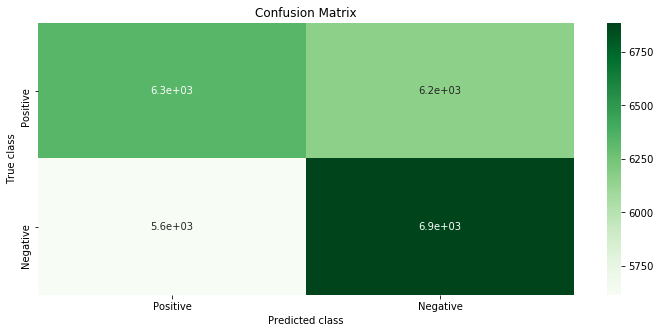

In [147]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, ypred)
plot_cnf_matrix(cm, "cm")

In [149]:
# Save model and weights for future use. 
model.save('models/exp1_model.h5')
model.save_weights('exp1_weights.h5')

## Retrive the output of each layer in keras for a given single test sample from the trained model you built

In [150]:
from keras.models import load_model
model = load_model('models/exp1_model.h5')

In [151]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 8)            80000     
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 1)                 10        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 2         
Total params: 80,012
Trainable params: 80,012
Non-trainable params: 0
_________________________________________________________________


In [152]:
#retrieve output at each layer

from keras import backend as K

inp = model.input                               # input placeholder
outputs = [layer.output for layer in model.layers ]          # all layer outputs
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

In [153]:
# getting output at each layer for test sample

sample_pos = 100  # btw 0~24999
testSample = x_test_pad[sample_pos][np.newaxis,...] # get the test sample

layer_outs = [func([testSample, 1.]) for func in functors] # get the output at each layer for the test sample

# print output at each layer
for idx, layer in enumerate(model.layers):
    print("\nLayer name: {}, Shape: {}: ".format(layer.name, layer_outs[idx][0][0].shape))
    print("Layer output")
    print(layer_outs[idx][0][0])


Layer name: embedding_4, Shape: (300, 8): 
Layer output
[[-0.04013146 -0.02682588 -0.0443143  ... -0.01225164 -0.00495133
  -0.05599364]
 [-0.04013146 -0.02682588 -0.0443143  ... -0.01225164 -0.00495133
  -0.05599364]
 [-0.04013146 -0.02682588 -0.0443143  ... -0.01225164 -0.00495133
  -0.05599364]
 ...
 [-0.00209993  0.01133369  0.00346888 ...  0.02624813 -0.00444381
  -0.06855737]
 [-0.02206863  0.0398508  -0.05593491 ... -0.04494559  0.00158423
   0.00316717]
 [-0.03653032 -0.01963209 -0.04409729 ... -0.01067043  0.02560998
   0.02877974]]

Layer name: simple_rnn_13, Shape: (1,): 
Layer output
[0.28396037]

Layer name: dense_13, Shape: (1,): 
Layer output
[0.43129978]
